In [2]:
import collections
import warnings

import numpy
import pandas
import sklearn.cluster
import sklearn.cross_validation
import sklearn.decomposition
import sklearn.grid_search
import sklearn.ensemble
import sklearn.linear_model
import sklearn.manifold
import sklearn.metrics
import sklearn.naive_bayes
import sklearn.neighbors
import sklearn.svm

In [3]:
from matplotlib import pyplot
pyplot.style.use("ggplot")
%matplotlib inline

In [4]:
train_data = pandas.read_csv("train.csv.gz").values
X, y = train_data[:, 1:] / 255.0, train_data[:, 0]
print("X:", X.shape)
print("y:", y.shape)

X: (42000, 784)
y: (42000,)


In [5]:
X_test = pandas.read_csv("test.csv.gz").values / 255.0
print("Test X:", X_test.shape)

Test X: (28000, 784)


# PCA

In [12]:
pca = sklearn.decomposition.PCA().fit(X)

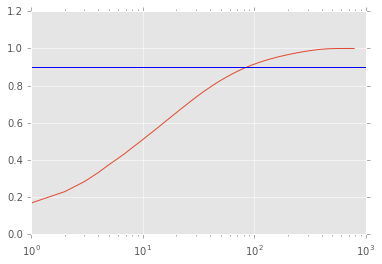

In [13]:
pyplot.plot(numpy.cumsum(pca.explained_variance_ratio_))
pyplot.axhline(y=0.9)
pyplot.xscale("log")
pyplot.show()

In [14]:
X_pca = pca.transform(X)

In [15]:
X_test_pca = pca.transform(X_test)

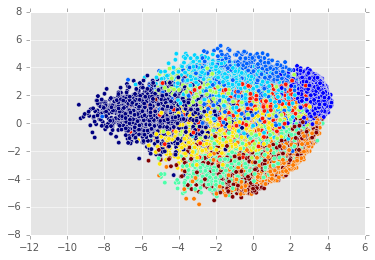

In [16]:
pyplot.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
pyplot.show()

# Random Forest

In [49]:
numpy.random.seed(0)

rfc_model = sklearn.grid_search.GridSearchCV(sklearn.ensemble.RandomForestClassifier(
    n_jobs=-1,
    class_weight="balanced",
    max_features="sqrt",
), {
    "n_estimators": [500],
    "max_depth": [100],
}, verbose=3).fit(X, y)

print("Score:", rfc_model.best_score_)
print("Params:", rfc_model.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] n_estimators=500, max_depth=100 .................................
[CV] ........ n_estimators=500, max_depth=100, score=0.963153 -  59.6s
[CV] n_estimators=500, max_depth=100 .................................
[CV] ........ n_estimators=500, max_depth=100, score=0.963495 -  52.1s
[CV] n_estimators=500, max_depth=100 .................................
[CV] ........ n_estimators=500, max_depth=100, score=0.966209 -  45.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.6min finished


Score: 0.964285714286
Params: {'n_estimators': 500, 'max_depth': 100}


In [50]:
y_test = numpy.array(list(enumerate(rfc_model.best_estimator_.predict(X_test), start=1)))
print("Y test:", y_test.shape)
numpy.savetxt("answer_rfc.csv", y_test, fmt="%d,\"%d\"", header="\"ImageId\",\"Label\"", comments="")

Y test: (28000, 2)


# Bayes

In [51]:
numpy.random.seed(0)

for model in [
    sklearn.naive_bayes.GaussianNB(),
    sklearn.naive_bayes.BernoulliNB(),
    sklearn.naive_bayes.MultinomialNB(),
]:
    print("%s: %s" % (model, sklearn.cross_validation.cross_val_score(model, X, y).mean()))

GaussianNB(): 0.562237774695
BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True): 0.832999717714
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True): 0.823642431638


## PCA + Bayes

In [52]:
numpy.random.seed(0)

for model in [
    sklearn.naive_bayes.GaussianNB(),
    sklearn.naive_bayes.BernoulliNB(),
]:
    print("%s: %s" % (model, sklearn.cross_validation.cross_val_score(model, X_transformed[:, :100], y).mean()))

GaussianNB(): 0.869833232797
BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True): 0.738832880561


# SVD

In [6]:
svd = sklearn.decomposition.TruncatedSVD(n_components=100).fit(X)
X_svd = svd.transform(X)

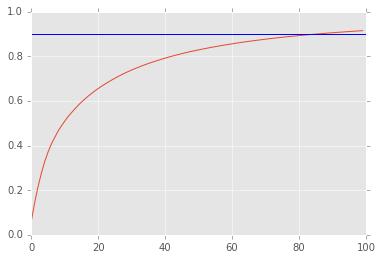

In [7]:
pyplot.plot(numpy.cumsum(svd.explained_variance_ratio_))
pyplot.axhline(y=0.9)
pyplot.show()

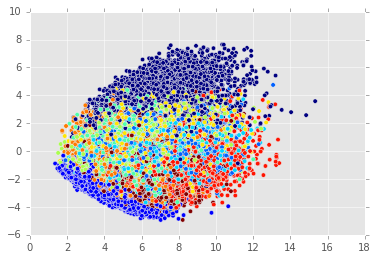

In [8]:
pyplot.scatter(X_svd[:, 0], X_svd[:, 1], c=y)
pyplot.show()

# PCA + kNN

In [88]:
numpy.random.seed(0)

for n_components in range(30, 35):
    X_pca = sklearn.decomposition.PCA(n_components=n_components).fit_transform(numpy.vstack([X, X_test]))
    estimator = sklearn.neighbors.KNeighborsClassifier(weights="distance", n_jobs=-1)
    knn_model = sklearn.grid_search.GridSearchCV(estimator, {"n_neighbors": [2, 3, 4, 5, 6]}).fit(X_pca[:X.shape[0], :], y)

    print("Components:", n_components)
    print("Score:", knn_model.best_score_)
    print("Params:", knn_model.best_params_)

Components: 30
Score: 0.973452380952
Params: {'n_neighbors': 4}
Components: 31
Score: 0.973380952381
Params: {'n_neighbors': 4}
Components: 32
Score: 0.973547619048
Params: {'n_neighbors': 4}
Components: 33
Score: 0.973785714286
Params: {'n_neighbors': 4}
Components: 34
Score: 0.973976190476
Params: {'n_neighbors': 4}


In [33]:
X_pca_knn = sklearn.decomposition.PCA(n_components=34).fit_transform(numpy.vstack([X, X_test]))

In [34]:
pca_knn_model = \
    sklearn.neighbors.KNeighborsClassifier(weights="distance", n_jobs=-1, n_neighbors=4).\
    fit(X_pca_knn[:X.shape[0], :], y)

In [35]:
y_test_answer = numpy.array(list(enumerate(pca_knn_model.predict(X_pca_knn[X.shape[0]:, :]), start=1)))
numpy.savetxt("answer_pca_knn.csv", y_test_answer, fmt="%d,\"%d\"", header="\"ImageId\",\"Label\"", comments="")
print(y_test_answer)

[[    1     2]
 [    2     0]
 [    3     9]
 ..., 
 [27998     3]
 [27999     9]
 [28000     2]]


# K-Means

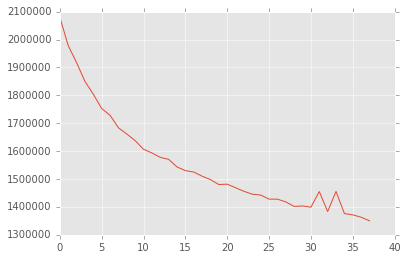

In [9]:
numpy.random.seed(0)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    inertias = [
        sklearn.cluster.MiniBatchKMeans(n_clusters=n_clusters).fit(X).inertia_
        for n_clusters in range(2, 40)
    ]

pyplot.plot(inertias)
pyplot.show()

# PCA + SVC

In [11]:
numpy.random.seed(0)

for n_components in range(25, 45, 5):
    pca_svc_model = sklearn.grid_search.GridSearchCV(sklearn.svm.SVC(), {
        "C": [1.0, 10.0, 100.0],
        "class_weight": [None, "balanced"],
    }, n_jobs=-1).fit(X_pca[:, :n_components], y)

    print()
    print("N:", n_components)
    print("Score:", pca_svc_model.best_score_)
    print("Params:", pca_svc_model.best_params_)


N: 25
Score: 0.98
Params: {'C': 10.0, 'class_weight': 'balanced'}

N: 30
Score: 0.981404761905
Params: {'C': 10.0, 'class_weight': None}

N: 35
Score: 0.981904761905
Params: {'C': 10.0, 'class_weight': 'balanced'}

N: 40
Score: 0.981595238095
Params: {'C': 10.0, 'class_weight': None}


In [12]:
numpy.random.seed(0)

for n_components in range(33, 37):
    pca_svc_model = sklearn.grid_search.GridSearchCV(sklearn.svm.SVC(), {
        "C": [5.0, 10.0, 20.0],
        "class_weight": ["balanced"],
    }, n_jobs=-1).fit(X_pca[:, :n_components], y)

    print()
    print("N:", n_components)
    print("Score:", pca_svc_model.best_score_)
    print("Params:", pca_svc_model.best_params_)


N: 33
Score: 0.982071428571
Params: {'C': 5.0, 'class_weight': 'balanced'}

N: 34
Score: 0.982142857143
Params: {'C': 5.0, 'class_weight': 'balanced'}

N: 35
Score: 0.981904761905
Params: {'C': 10.0, 'class_weight': 'balanced'}

N: 36
Score: 0.981976190476
Params: {'C': 5.0, 'class_weight': 'balanced'}


In [13]:
%%time

numpy.random.seed(0)

pca_svc_model = sklearn.grid_search.GridSearchCV(sklearn.svm.SVC(class_weight="balanced"), {
    "C": [1.5, 2.5, 5.0, 7.5, 9.0],
}, n_jobs=-1).fit(X_pca[:, :34], y)

print("Score:", pca_svc_model.best_score_)
print("Params:", pca_svc_model.best_params_)

Score: 0.982142857143
Params: {'C': 5.0}
CPU times: user 21.2 s, sys: 314 ms, total: 21.5 s
Wall time: 2min 53s


In [28]:
%%time

numpy.random.seed(0)

pca_svc_model = sklearn.grid_search.GridSearchCV(sklearn.svm.SVC(
    class_weight="balanced",
    decision_function_shape="ovr",
), {
    "C": numpy.linspace(4.5, 5.5, num=11),
}, n_jobs=-1, verbose=3).fit(X_pca[:, :34], y)

print("Score:", pca_svc_model.best_score_)
print("Params:", pca_svc_model.best_params_)

Fitting 3 folds for each of 11 candidates, totalling 33 fits
[CV] C=4.5 ...........................................................
[CV] C=4.5 ...........................................................
[CV] C=4.5 ...........................................................
[CV] C=4.6 ...........................................................
[CV] .................................. C=4.5, score=0.980640 -  33.7s
[CV] C=4.6 ...........................................................
[CV] .................................. C=4.5, score=0.982791 -  34.0s
[CV] C=4.6 ...........................................................
[CV] .................................. C=4.6, score=0.982862 -  34.3s
[CV] C=4.7 ...........................................................
[CV] .................................. C=4.5, score=0.982640 -  35.0s
[CV] C=4.7 ...........................................................
[CV] .................................. C=4.6, score=0.980569 -  34.3s
[CV] C=4.7 .....

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.5min


[CV] .................................. C=5.3, score=0.980783 -  30.0s
[CV] C=5.4 ...........................................................
[CV] .................................. C=5.3, score=0.983076 -  30.6s
[CV] C=5.4 ...........................................................
[CV] .................................. C=5.3, score=0.982783 -  30.7s
[CV] C=5.5 ...........................................................
[CV] .................................. C=5.4, score=0.983148 -  30.7s
[CV] C=5.5 ...........................................................
[CV] .................................. C=5.4, score=0.980783 -  34.5s
[CV] C=5.5 ...........................................................
[CV] .................................. C=5.4, score=0.982712 -  35.4s
[CV] .................................. C=5.5, score=0.983076 -  34.8s
[CV] .................................. C=5.5, score=0.980783 -  34.6s
[CV] .................................. C=5.5, score=0.982712 -  18.4s


[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:  4.9min finished


Score: 0.982214285714
Params: {'C': 4.9000000000000004}
CPU times: user 23.8 s, sys: 469 ms, total: 24.2 s
Wall time: 5min 13s


In [32]:
y_test_answer = numpy.array(list(enumerate(pca_svc_model.predict(X_test_pca[:, :34]), start=1)))
numpy.savetxt("answer_pca_svc.csv", y_test_answer, fmt="%d,\"%d\"", header="\"ImageId\",\"Label\"", comments="")
print(y_test_answer)

[[    1     2]
 [    2     0]
 [    3     9]
 ..., 
 [27998     3]
 [27999     9]
 [28000     2]]
